# 使用quantOS系统实现跨品种套利策略

## 本段代码利用quantOS的事件驱动框架实现了基于协整的跨品种套利策略

In [1]:
# -*- encoding: utf-8 -*-
import sys
# sys.path = ['D:/jaqs_git'] + sys.path
sys.path.append('D:/tmp/JAQS')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
# sns.set_style('darkgrid')
%matplotlib inline
from __future__ import print_function
from __future__ import absolute_import
import numpy as np
import statsmodels.api as sm

from jaqs.trade import EventDrivenStrategy
from jaqs.trade import common, model

from jaqs.data import RemoteDataService
from jaqs.trade import EventBacktestInstance
from jaqs.trade import BacktestTradeApi
from jaqs.trade import PortfolioManager
import jaqs.trade.analyze as ana
import jaqs.util as jutil
import time
import pandas as pd
import os

from jaqs.data.dataview import DataView
from jaqs.data import DataView

C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\jaqs\trade\analyze\analyze.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  

### 设置文件存储路径

In [2]:
dataview_dir_path = 'demoStrategy/dataview'
backtest_result_dir_path = 'demoStrategy'
result_dir_path = '../../output/calendar_spread'

### 设置登录信息

In [3]:
phone = os.environ.get('QUANTOS_USER')
token = os.environ.get('QUANTOS_TOKEN')

data_config = {
  "remote.data.address": "tcp://data.quantos.org:8910",
  "remote.data.username": phone,
  "remote.data.password": token
}
trade_config = {
  "remote.trade.address": "tcp://gw.quantos.org:8901",
  "remote.trade.username": phone,
  "remote.trade.password": token
}

dv = DataView()
ds = RemoteDataService()
ds.init_from_config(data_config)


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    login success 



'0,'

### 设置参数

In [4]:
symbol_list = ['rb1710.SHF', 'hc1710.SHF']
start_date, end_date = 20170315, 20170831
date_list = ds.query_trade_dates(start_date, end_date)

### 提取价格时间序列

In [5]:
df1_all = pd.DataFrame()
for single_date in date_list:
    df1, _= ds.bar(symbol_list[0], start_time = 90000, end_time= 160000, trade_date = single_date, freq = '1M', fields = 'close')
    df1   = df1[['close', 'symbol', 'time', 'trade_date']]
    df1.columns = ['close_1', 'symbol_1', 'time', 'trade_date']
    df1_all = pd.concat([df1_all, df1], axis = 0)

In [6]:
df2_all = pd.DataFrame()
for single_date in date_list:
    df2, _= ds.bar(symbol_list[1], start_time = 90000, end_time= 160000, trade_date = single_date, freq = '1M', fields = 'close')
    df2   = df2[['close', 'symbol', 'time', 'trade_date']]
    df2.columns = ['close_2', 'symbol_2', 'time', 'trade_date']
    df2_all = pd.concat([df2_all, df2], axis = 0)

In [7]:
df_all = pd.merge(left = df1_all, right = df2_all, how = 'left', on = ['trade_date', 'time'])

In [8]:
df_all['gap'] = df_all['close_2'] - df_all['close_1']

## 第一步：检验两组价格序列是否有协整关系

### 1. 计算两组价格时间序列相关系数并画图展示

In [9]:
x, y = df_all['close_1'], df_all['close_2']

                            OLS Regression Results                            
Dep. Variable:                close_2   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 8.669e+05
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        19:16:03   Log-Likelihood:            -1.4809e+05
No. Observations:               26325   AIC:                         2.962e+05
Df Residuals:                   26323   BIC:                         2.962e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -156.8018      3.803    -41.235      0.0

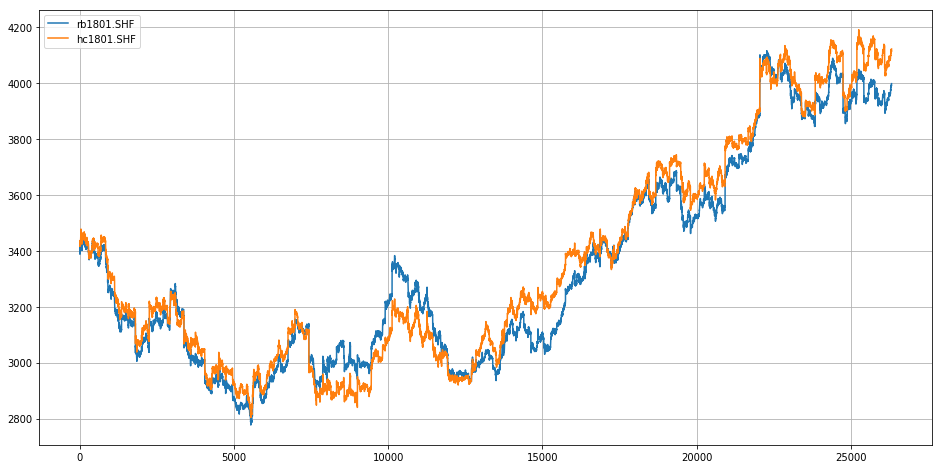

In [10]:
plt = x.plot(figsize = (16,8))
#spread = x - y
#spread.plot(figsize = (16,8))
plt.plot(y)
plt.grid()
X = sm.add_constant(x)
result = (sm.OLS(y, X)).fit()
params = result.params[1]
print(result.summary())
plt.legend(['rb1801.SHF', 'hc1801.SHF'], loc = 'best')

### 2. 画出数据拟合线

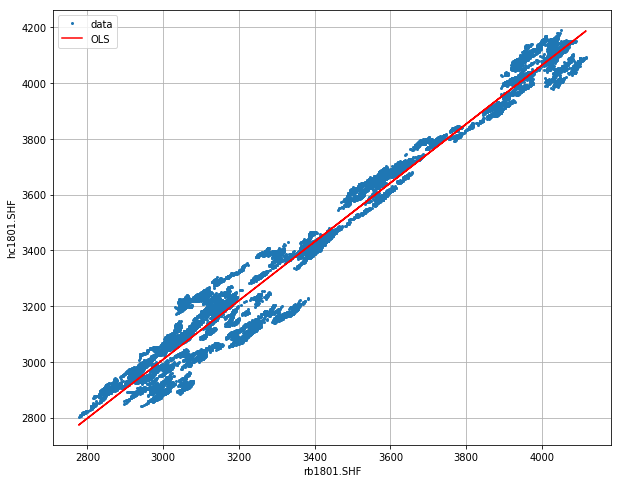

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, y, 'o', label="data", markersize = 2)
plt.xlabel('rb1801.SHF')
plt.ylabel('hc1801.SHF')
ax.grid()
ax.plot(x, result.fittedvalues, 'r', label="OLS")
ax.legend(loc='best')

### 3. 验证两个价格序列是否存在协整关系

In [12]:
result = sm.tsa.stattools.coint(x, y)
print('p-value of cointegration test is: %.2f' % result[1])

p-value of cointegration test is: 0.48


In [13]:
sm.tsa.stattools.adfuller(y-params*x)

(-1.9265071656556643,
 0.3196958699611745,
 13,
 26311,
 {'1%': -3.4305985628862015,
  '10%': -2.566828473899184,
  '5%': -2.861649857511274},
 119095.88536469982)

### 4. 依照1中线性回归所得比例，我们画出他们价差的平稳序列，并计算价差的zscore时间序列并画图展示。可以看出，虽然价差上下波动，但都会回归中间的均值

In [14]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [15]:
dif_price = zscore(y - params * x)

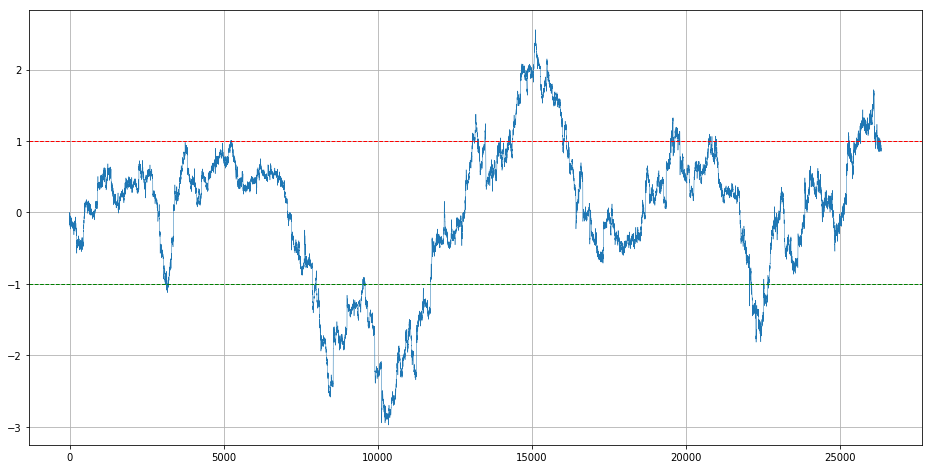

In [16]:
plt = dif_price.plot(figsize = (16,8), linewidth = 0.5)
plt.grid()
plt.axhline(1.0, color = 'red', linestyle = '--', linewidth = 1)
plt.axhline(-1.0, color = 'green', linestyle = '--', linewidth = 1)

In [17]:
dif_series = y - params * x
dif_mean   = dif_series.mean()
dif_std    = dif_series.std()

In [18]:
print('价差序列的均值为: %.2f' % dif_mean)
print('价差序列的标准差为: %.2f' % dif_std)

价差序列的均值为: -156.80
价差序列的标准差为: 67.12


## 第二步：根据上面研究结果构造策略

### 设置策略参数

In [52]:
props = {
    "symbol"                : ','.join(symbol_list),
    "start_date"            : start_date,
    "end_date"              : end_date,
    "bar_type"              : "1M",
    "init_balance"          : 1e4,
    "bufferSize"            : 30,
    "commission_rate"            : 0.00005
}
props.update(data_config)
props.update(trade_config)

### 定义策略

In [53]:
class CalendarSpread(EventDrivenStrategy):
    def __init__(self):
        super(CalendarSpread, self).__init__()
        
        self.symbol      = ''
        self.s1          = ''
        self.s2          = ''
        self.quote1      = None
        self.quote2      = None
        
        self.bufferSize  = 0
        self.bufferCount = 0
        self.spreadList  = ''
        self.trade_side  = 0

        self.rb_pos       = 0
        self.hc_pos       = 0

        self.unfilled_tasks = []


    def init_from_config(self, props):
        super(CalendarSpread, self).init_from_config(props)
        
        self.symbol       = props.get('symbol')
        self.init_balance = props.get('init_balance')
        self.bufferSize   = props.get('bufferSize')
        self.s1, self.s2  = self.symbol.split(',')
        self.spreadList = np.zeros(self.bufferSize)
        
        self.output = True

    def on_cycle(self):
        pass
    
    def on_tick(self, quote):
        pass

    def buy(self, quote, price, size):
        task_id, msg = self.ctx.trade_api.place_order(quote.symbol, 'Buy', price, size)
        self.unfilled_tasks.append(task_id)
        # self.order_tasks.append(task_id)

    def sell(self, quote, price, size):
        task_id, msg = self.ctx.trade_api.place_order(quote.symbol, 'Sell', price, size)
        self.unfilled_tasks.append(task_id)
        # self.order_tasks.append(task_id)

    def long_spread(self, quote1, quote2):
        self.buy(quote1, quote1.close, 1)
        self.sell(quote2, quote2.close, 1)

    def short_spread(self, quote1, quote2):
        self.buy(quote2, quote2.close, 1)
        self.sell(quote1, quote1.close, 1)
    
    def on_bar(self, quote):

        q1 = quote.get(self.s1)
        q2 = quote.get(self.s2)
        self.quote1 = q1
        self.quote2 = q2
    
        spread = q1.close - q2.close
    
        self.spreadList[0:self.bufferSize - 1] = self.spreadList[1:self.bufferSize]
        self.spreadList[-1] = spread
        self.bufferCount += 1
    
        if self.bufferCount <= self.bufferSize:
            return

        if (q1.time > 145900 and q1.time < 210100) or (q1.time < 90100):
            return

#         print(self.rb_pos, self.hc_pos)

        # cancel all existing orders
        if self.unfilled_tasks :
            for task_id in self.unfilled_tasks:
                self.ctx.trade_api.cancel_order(task_id=task_id)
                self.unfilled_tasks.remove(task_id)

                # info of canceled order
                order_symbol = self.ctx.pm.tasks[task_id].data.symbol
                order_tradeside = self.ctx.pm.tasks[task_id].data.entrust_action
                order_size = self.ctx.pm.tasks[task_id].data.entrust_size

                # resend order
                if order_tradeside == 'Buy':
                    if order_symbol == 'rb1710.SHF':
                        self.buy(q1, q1.close, order_size)
                    else:
                        self.buy(q2, q2.close, order_size)
                else:
                    if order_symbol == 'rb1710.SHF':
                        self.sell(q1, q1.close, order_size)
                    else:
                        self.sell(q2, q2.close, order_size)

        current_mean = np.mean(self.spreadList)
        current_std = np.std(self.spreadList)

        # 当最新spread超过均值+1倍std时：
        if spread > current_mean + 2.5 * current_std and spread != 0:
            if self.trade_side == 0:
                self.short_spread(q1, q2)
                self.trade_side = -1
            elif self.trade_side == 1:
                self.short_spread(q1, q2)
                self.short_spread(q1, q2)
                self.trade_side = -1
            else:
                pass
        # 当最新spread低于均值-1倍std时：
        elif spread < current_mean - 2.5 * current_std and spread != 0:
            if self.trade_side == 0:
                self.long_spread(q1, q2)
                self.trade_side = 1
            elif self.trade_side == -1:
                self.long_spread(q1, q2)
                self.long_spread(q1, q2)
                self.trade_side = 1
            else:
                pass

        # 平仓逻辑

        elif spread < current_mean and spread != 0:
            if self.trade_side == -1:
                self.long_spread(q1, q2)
                self.trade_side = 0
            else:
                pass

        elif spread > current_mean and spread != 0:
            if self.trade_side == 1:
                self.short_spread(q1, q2)
                self.trade_side = 0
            else:
                pass

    def on_trade(self, ind):
        if self.output:
            print("\nStrategy on trade: ")
            print(ind)
            print(self.ctx.pm.get_trade_stat(ind.symbol))

        # get the position of rb and hc
        self.unfilled_tasks.remove(ind.task_id)
        if ind.symbol[:2] == 'rb':
            self.rb_pos = self.ctx.pm.get_pos(ind.symbol)
        else:
            self.hc_pos = self.ctx.pm.get_pos(ind.symbol)


    def on_order_status(self, ind):
        if self.output:
            print("\nStrategy on order status: ")
            print(ind)
        
    def on_task_rsp(self, rsp):
        if self.output:
            print("\nStrategy on task rsp: ")
            print(rsp)

    def on_order_rsp(self, rsp):
        if self.output:
            print("\nStrategy on order rsp: ")
            print(rsp)
    
    def on_task_status(self, ind):
        if self.output:
            print("\nStrategy on task ind: ")
            print(ind)


In [54]:
def run_strategy():
    tapi = BacktestTradeApi()
    ins = EventBacktestInstance()

    ds = RemoteDataService()
    strat = CalendarSpread()
    pm = PortfolioManager()

    context = model.Context(data_api=ds, trade_api=tapi, instance=ins,
                            strategy=strat, pm=pm)

    ins.init_from_config(props)
    ins.run()
    ins.save_results(folder_path=result_dir_path)

In [55]:
def analyze():
    ta = ana.EventAnalyzer()
    
    ds = RemoteDataService()
    ds.init_from_config(data_config)
    
    ta.initialize(data_server_=ds, file_folder=result_dir_path)
    
    ta.do_analyze(result_dir=result_dir_path, selected_sec=props['symbol'].split(','))


### 执行策略

In [56]:
run_strategy()


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    Already login as 17321165656, skip init_from_config
on_new_day in trade 20170315

Strategy on order status: 
Accepted  |  20170315(       0) Buy    hc1710.SHF@3367.000  size = 1

Strategy on order status: 
Accepted  |  20170315(       0) Sell   rb1710.SHF@3352.000  size = 1

Strategy on order status: 
Filled    |  20170315(       0) Buy    hc1710.SHF@3367.000  size = 1

Strategy on trade: 
20170315(  223500) Buy    hc1710.SHF@3367.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703150001  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170315(       0) Sell   rb1710.SHF@3352.000  size = 1

Strategy on trade: 
20170315(  223500) Sell   rb1710.SHF@3352.000  size = 1
        Want Size      Filled Size  
Buy            0         


Strategy on order status: 
Accepted  |  20170316(       0) Buy    rb1710.SHF@3422.000  size = 1

Strategy on order status: 
Accepted  |  20170316(       0) Sell   hc1710.SHF@3445.000  size = 1

Strategy on order status: 
Filled    |  20170316(       0) Buy    rb1710.SHF@3422.000  size = 1

Strategy on trade: 
20170316(  213600) Buy    rb1710.SHF@3422.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703160026  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170316(       0) Sell   hc1710.SHF@3445.000  size = 1

Strategy on trade: 
20170316(  213600) Sell   hc1710.SHF@3445.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703160027  |  task_stat


Strategy on order status: 
Accepted  |  20170317(       0) Buy    rb1710.SHF@3415.000  size = 1

Strategy on order status: 
Accepted  |  20170317(       0) Sell   hc1710.SHF@3423.000  size = 1

Strategy on order status: 
Filled    |  20170317(       0) Buy    rb1710.SHF@3415.000  size = 1

Strategy on trade: 
20170317(  210900) Buy    rb1710.SHF@3415.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703170054  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170317(       0) Sell   hc1710.SHF@3423.000  size = 1

Strategy on trade: 
20170317(  210900) Sell   hc1710.SHF@3423.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703170055  |  task_stat


Strategy on order status: 
Accepted  |  20170320(       0) Buy    hc1710.SHF@3398.000  size = 1

Strategy on order status: 
Accepted  |  20170320(       0) Sell   rb1710.SHF@3373.000  size = 1

Strategy on order status: 
Filled    |  20170320(       0) Buy    hc1710.SHF@3398.000  size = 1

Strategy on trade: 
20170320(  213500) Buy    hc1710.SHF@3398.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703200093  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170320(       0) Sell   rb1710.SHF@3373.000  size = 1

Strategy on trade: 
20170320(  213500) Sell   rb1710.SHF@3373.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703200094  |  task_stat

Strategy on order status: 
Accepted  |  20170321(       0) Buy    hc1710.SHF@3364.000  size = 1

Strategy on order status: 
Accepted  |  20170321(       0) Sell   rb1710.SHF@3336.000  size = 1

Strategy on order status: 
Filled    |  20170321(       0) Buy    hc1710.SHF@3364.000  size = 1

Strategy on trade: 
20170321(  210200) Buy    hc1710.SHF@3364.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703210119  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170321(       0) Sell   rb1710.SHF@3336.000  size = 1

Strategy on trade: 
20170321(  210200) Sell   rb1710.SHF@3336.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703210120  |  task_statu

Strategy on order status: 
Accepted  |  20170322(       0) Buy    hc1710.SHF@3267.000  size = 1

Strategy on order status: 
Accepted  |  20170322(       0) Sell   rb1710.SHF@3217.000  size = 1

Strategy on order status: 
Filled    |  20170322(       0) Buy    hc1710.SHF@3267.000  size = 1

Strategy on trade: 
20170322(  210900) Buy    hc1710.SHF@3267.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703220139  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170322(       0) Sell   rb1710.SHF@3217.000  size = 1

Strategy on trade: 
20170322(  210900) Sell   rb1710.SHF@3217.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703220140  |  task_statu

Strategy on order status: 
Accepted  |  20170323(       0) Buy    hc1710.SHF@3192.000  size = 1

Strategy on order status: 
Accepted  |  20170323(       0) Sell   rb1710.SHF@3144.000  size = 1

Strategy on order status: 
Filled    |  20170323(       0) Buy    hc1710.SHF@3192.000  size = 1

Strategy on trade: 
20170323(  215000) Buy    hc1710.SHF@3192.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703230177  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170323(       0) Sell   rb1710.SHF@3144.000  size = 1

Strategy on trade: 
20170323(  215000) Sell   rb1710.SHF@3144.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703230178  |  task_statu

Strategy on order status: 
Accepted  |  20170324(       0) Buy    hc1710.SHF@3140.000  size = 1

Strategy on order status: 
Accepted  |  20170324(       0) Sell   rb1710.SHF@3117.000  size = 1

Strategy on order status: 
Filled    |  20170324(       0) Buy    hc1710.SHF@3140.000  size = 1

Strategy on trade: 
20170324(  210200) Buy    hc1710.SHF@3140.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703240196  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170324(       0) Sell   rb1710.SHF@3117.000  size = 1

Strategy on trade: 
20170324(  210200) Sell   rb1710.SHF@3117.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703240197  |  task_statu


Strategy on order status: 
Accepted  |  20170327(       0) Buy    hc1710.SHF@3084.000  size = 1

Strategy on order status: 
Accepted  |  20170327(       0) Sell   rb1710.SHF@3048.000  size = 1

Strategy on order status: 
Filled    |  20170327(       0) Buy    hc1710.SHF@3084.000  size = 1

Strategy on trade: 
20170327(   90300) Buy    hc1710.SHF@3084.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703270214  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170327(       0) Sell   rb1710.SHF@3048.000  size = 1

Strategy on trade: 
20170327(   90300) Sell   rb1710.SHF@3048.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703270215  |  task_stat

Strategy on order status: 
Accepted  |  20170329(       0) Buy    rb1710.SHF@3085.000  size = 1

Strategy on order status: 
Accepted  |  20170329(       0) Sell   hc1710.SHF@3134.000  size = 1

Strategy on order status: 
Filled    |  20170329(       0) Buy    rb1710.SHF@3085.000  size = 1

Strategy on trade: 
20170329(  213300) Buy    rb1710.SHF@3085.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703290266  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170329(       0) Sell   hc1710.SHF@3134.000  size = 1

Strategy on trade: 
20170329(  213300) Sell   hc1710.SHF@3134.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703290267  |  task_statu


Strategy on order status: 
Accepted  |  20170330(       0) Buy    rb1710.SHF@3160.000  size = 1

Strategy on order status: 
Accepted  |  20170330(       0) Sell   hc1710.SHF@3201.000  size = 1

Strategy on order status: 
Filled    |  20170330(       0) Buy    rb1710.SHF@3160.000  size = 1

Strategy on trade: 
20170330(  210300) Buy    rb1710.SHF@3160.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201703300288  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170330(       0) Sell   hc1710.SHF@3201.000  size = 1

Strategy on trade: 
20170330(  210300) Sell   hc1710.SHF@3201.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703300289  |  task_stat

Strategy on order status: 
Accepted  |  20170331(       0) Buy    rb1710.SHF@3164.000  size = 1

Strategy on order status: 
Accepted  |  20170331(       0) Sell   hc1710.SHF@3201.000  size = 1

Strategy on order status: 
Filled    |  20170331(       0) Buy    rb1710.SHF@3164.000  size = 1

Strategy on trade: 
20170331(  214400) Buy    rb1710.SHF@3164.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703310321  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170331(       0) Sell   hc1710.SHF@3201.000  size = 1

Strategy on trade: 
20170331(  214400) Sell   hc1710.SHF@3201.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201703310322  |  task_statu


Strategy on order status: 
Accepted  |  20170406(       0) Buy    rb1710.SHF@3232.000  size = 1

Strategy on order status: 
Accepted  |  20170406(       0) Sell   hc1710.SHF@3188.000  size = 1

Strategy on order status: 
Filled    |  20170406(       0) Buy    rb1710.SHF@3232.000  size = 1

Strategy on trade: 
20170406(  210300) Buy    rb1710.SHF@3232.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704060365  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170406(       0) Sell   hc1710.SHF@3188.000  size = 1

Strategy on trade: 
20170406(  210300) Sell   hc1710.SHF@3188.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704060366  |  task_stat


Strategy on order status: 
Accepted  |  20170407(       0) Buy    rb1710.SHF@3141.000  size = 1

Strategy on order status: 
Accepted  |  20170407(       0) Sell   hc1710.SHF@3150.000  size = 1

Strategy on order status: 
Filled    |  20170407(       0) Buy    rb1710.SHF@3141.000  size = 1

Strategy on trade: 
20170407(  210200) Buy    rb1710.SHF@3141.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704070384  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170407(       0) Sell   hc1710.SHF@3150.000  size = 1

Strategy on trade: 
20170407(  210200) Sell   hc1710.SHF@3150.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704070385  |  task_stat

Strategy on order status: 
Accepted  |  20170410(       0) Buy    hc1710.SHF@3065.000  size = 1

Strategy on order status: 
Accepted  |  20170410(       0) Sell   rb1710.SHF@3034.000  size = 1

Strategy on order status: 
Filled    |  20170410(       0) Buy    hc1710.SHF@3065.000  size = 1

Strategy on trade: 
20170410(  211100) Buy    hc1710.SHF@3065.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704100409  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170410(       0) Sell   rb1710.SHF@3034.000  size = 1

Strategy on trade: 
20170410(  211100) Sell   rb1710.SHF@3034.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                2   


Strategy on task ind: 
task_id = 201704100410  |  task_statu


Strategy on order status: 
Accepted  |  20170411(       0) Buy    hc1710.SHF@3060.000  size = 1

Strategy on order status: 
Accepted  |  20170411(       0) Sell   rb1710.SHF@3020.000  size = 1

Strategy on order status: 
Filled    |  20170411(       0) Buy    hc1710.SHF@3060.000  size = 1

Strategy on trade: 
20170411(  220000) Buy    hc1710.SHF@3060.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704110445  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170411(       0) Sell   rb1710.SHF@3020.000  size = 1

Strategy on trade: 
20170411(  220000) Sell   rb1710.SHF@3020.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704110446  |  task_stat

Strategy on order status: 
Accepted  |  20170412(       0) Buy    hc1710.SHF@2947.000  size = 1

Strategy on order status: 
Accepted  |  20170412(       0) Sell   rb1710.SHF@2923.000  size = 1

Strategy on order status: 
Filled    |  20170412(       0) Buy    hc1710.SHF@2947.000  size = 1

Strategy on trade: 
20170412(   94200) Buy    hc1710.SHF@2947.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704120469  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170412(       0) Sell   rb1710.SHF@2923.000  size = 1

Strategy on trade: 
20170412(   94200) Sell   rb1710.SHF@2923.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704120470  |  task_statu


Strategy on order status: 
Accepted  |  20170413(       0) Buy    rb1710.SHF@2893.000  size = 1

Strategy on order status: 
Accepted  |  20170413(       0) Sell   hc1710.SHF@2919.000  size = 1

Strategy on order status: 
Filled    |  20170413(       0) Buy    rb1710.SHF@2893.000  size = 1

Strategy on trade: 
20170413(  210300) Buy    rb1710.SHF@2893.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704130489  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170413(       0) Sell   hc1710.SHF@2919.000  size = 1

Strategy on trade: 
20170413(  210300) Sell   hc1710.SHF@2919.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704130490  |  task_stat

Strategy on order status: 
Accepted  |  20170414(       0) Buy    rb1710.SHF@2963.000  size = 1

Strategy on order status: 
Accepted  |  20170414(       0) Sell   hc1710.SHF@3006.000  size = 1

Strategy on order status: 
Filled    |  20170414(       0) Buy    rb1710.SHF@2963.000  size = 1

Strategy on trade: 
20170414(  220200) Buy    rb1710.SHF@2963.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704140518  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170414(       0) Sell   hc1710.SHF@3006.000  size = 1

Strategy on trade: 
20170414(  220200) Sell   hc1710.SHF@3006.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704140519  |  task_statu


Strategy on order status: 
Accepted  |  20170417(       0) Buy    rb1710.SHF@2897.000  size = 1

Strategy on order status: 
Accepted  |  20170417(       0) Sell   hc1710.SHF@2954.000  size = 1

Strategy on order status: 
Filled    |  20170417(       0) Buy    rb1710.SHF@2897.000  size = 1

Strategy on trade: 
20170417(   90400) Buy    rb1710.SHF@2897.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704170538  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170417(       0) Sell   hc1710.SHF@2954.000  size = 1

Strategy on trade: 
20170417(   90400) Sell   hc1710.SHF@2954.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704170539  |  task_stat


Strategy on order status: 
Accepted  |  20170418(       0) Buy    hc1710.SHF@2967.000  size = 1

Strategy on order status: 
Accepted  |  20170418(       0) Sell   rb1710.SHF@2915.000  size = 1

Strategy on order status: 
Filled    |  20170418(       0) Buy    hc1710.SHF@2967.000  size = 1

Strategy on trade: 
20170418(  210200) Buy    hc1710.SHF@2967.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704180555  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170418(       0) Sell   rb1710.SHF@2915.000  size = 1

Strategy on trade: 
20170418(  210200) Sell   rb1710.SHF@2915.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704180556  |  task_stat


Strategy on order status: 
Accepted  |  20170419(       0) Buy    hc1710.SHF@2882.000  size = 1

Strategy on order status: 
Accepted  |  20170419(       0) Sell   rb1710.SHF@2828.000  size = 1

Strategy on order status: 
Filled    |  20170419(       0) Buy    hc1710.SHF@2882.000  size = 1

Strategy on trade: 
20170419(  210900) Buy    hc1710.SHF@2882.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704190573  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170419(       0) Sell   rb1710.SHF@2828.000  size = 1

Strategy on trade: 
20170419(  210900) Sell   rb1710.SHF@2828.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704190574  |  task_stat


Strategy on order status: 
Accepted  |  20170420(       0) Buy    hc1710.SHF@2913.000  size = 1

Strategy on order status: 
Accepted  |  20170420(       0) Sell   rb1710.SHF@2878.000  size = 1

Strategy on order status: 
Filled    |  20170420(       0) Buy    hc1710.SHF@2913.000  size = 1

Strategy on trade: 
20170420(  212000) Buy    hc1710.SHF@2913.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704200597  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170420(       0) Sell   rb1710.SHF@2878.000  size = 1

Strategy on trade: 
20170420(  212000) Sell   rb1710.SHF@2878.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704200598  |  task_stat


Strategy on order status: 
Accepted  |  20170421(       0) Buy    rb1710.SHF@2875.000  size = 1

Strategy on order status: 
Accepted  |  20170421(       0) Sell   hc1710.SHF@2907.000  size = 1

Strategy on order status: 
Filled    |  20170421(       0) Buy    rb1710.SHF@2875.000  size = 1

Strategy on trade: 
20170421(  214500) Buy    rb1710.SHF@2875.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704210621  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170421(       0) Sell   hc1710.SHF@2907.000  size = 1

Strategy on order status: 
Accepted  |  20170421(       0) Sell   hc1710.SHF@2906.000  size = 1

Strategy on order status: 
Filled    |  20170421(       0) Sell   hc1710.SHF@2906.000  size = 1

Strategy on trade: 
20170421(  214600) Sell   hc1710.SHF@2906.000  size = 1
        Want S

Strategy on order status: 
Accepted  |  20170424(       0) Buy    rb1710.SHF@2920.000  size = 1

Strategy on order status: 
Accepted  |  20170424(       0) Sell   hc1710.SHF@2956.000  size = 1

Strategy on order status: 
Filled    |  20170424(       0) Buy    rb1710.SHF@2920.000  size = 1

Strategy on trade: 
20170424(  211000) Buy    rb1710.SHF@2920.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704240651  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170424(       0) Sell   hc1710.SHF@2956.000  size = 1

Strategy on trade: 
20170424(  211000) Sell   hc1710.SHF@2956.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704240652  |  task_statu


Strategy on order status: 
Accepted  |  20170425(       0) Buy    rb1710.SHF@2923.000  size = 1

Strategy on order status: 
Accepted  |  20170425(       0) Sell   hc1710.SHF@2968.000  size = 1

Strategy on order status: 
Filled    |  20170425(       0) Buy    rb1710.SHF@2923.000  size = 1

Strategy on trade: 
20170425(   91100) Buy    rb1710.SHF@2923.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704250675  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170425(       0) Sell   hc1710.SHF@2968.000  size = 1

Strategy on trade: 
20170425(   91100) Sell   hc1710.SHF@2968.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704250676  |  task_stat



Strategy on order status: 
Cancelled  |  20170426(       0) Sell   rb1710.SHF@2948.000  size = 1

Strategy on order status: 
Accepted  |  20170426(       0) Sell   rb1710.SHF@2946.000  size = 1

Strategy on order status: 
Filled    |  20170426(       0) Sell   rb1710.SHF@2946.000  size = 1

Strategy on trade: 
20170426(  210900) Sell   rb1710.SHF@2946.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704260694  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Accepted  |  20170426(       0) Buy    rb1710.SHF@2943.000  size = 1

Strategy on order status: 
Accepted  |  20170426(       0) Sell   hc1710.SHF@2981.000  size = 1

Strategy on order status: 
Filled    |  20170426(       0) Buy    rb1710.SHF@2943.000  size = 1

Strategy on trade: 
20170426(  213200) Buy    rb1710.SHF@2943.000  size = 1
        Want 


Strategy on order status: 
Accepted  |  20170427(       0) Buy    hc1710.SHF@3025.000  size = 1

Strategy on order status: 
Accepted  |  20170427(       0) Sell   rb1710.SHF@2983.000  size = 1

Strategy on order status: 
Filled    |  20170427(       0) Buy    hc1710.SHF@3025.000  size = 1

Strategy on trade: 
20170427(  225800) Buy    hc1710.SHF@3025.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704270713  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170427(       0) Sell   rb1710.SHF@2983.000  size = 1

Strategy on order status: 
Accepted  |  20170427(       0) Sell   rb1710.SHF@2980.000  size = 1

Strategy on order status: 
Filled    |  20170427(       0) Sell   rb1710.SHF@2980.000  size = 1

Strategy on trade: 
20170427(  225900) Sell   rb1710.SHF@2980.000  size = 1
        Want S


Strategy on order status: 
Accepted  |  20170428(       0) Buy    hc1710.SHF@3072.000  size = 1

Strategy on order status: 
Accepted  |  20170428(       0) Sell   rb1710.SHF@3034.000  size = 1

Strategy on order status: 
Filled    |  20170428(       0) Buy    hc1710.SHF@3072.000  size = 1

Strategy on trade: 
20170428(  210300) Buy    hc1710.SHF@3072.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201704280742  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170428(       0) Sell   rb1710.SHF@3034.000  size = 1

Strategy on trade: 
20170428(  210300) Sell   rb1710.SHF@3034.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201704280743  |  task_stat


Strategy on order status: 
Accepted  |  20170503(       0) Buy    rb1710.SHF@3118.000  size = 1

Strategy on order status: 
Accepted  |  20170503(       0) Sell   hc1710.SHF@3109.000  size = 1

Strategy on order status: 
Filled    |  20170503(       0) Buy    rb1710.SHF@3118.000  size = 1

Strategy on trade: 
20170503(  214100) Buy    rb1710.SHF@3118.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705030780  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170503(       0) Sell   hc1710.SHF@3109.000  size = 1

Strategy on trade: 
20170503(  214100) Sell   hc1710.SHF@3109.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705030781  |  task_stat


Strategy on order status: 
Accepted  |  20170504(       0) Buy    hc1710.SHF@3087.000  size = 1

Strategy on order status: 
Accepted  |  20170504(       0) Sell   rb1710.SHF@3119.000  size = 1

Strategy on order status: 
Filled    |  20170504(       0) Buy    hc1710.SHF@3087.000  size = 1

Strategy on trade: 
20170504(  210200) Buy    hc1710.SHF@3087.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705040808  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170504(       0) Sell   rb1710.SHF@3119.000  size = 1

Strategy on trade: 
20170504(  210200) Sell   rb1710.SHF@3119.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705040809  |  task_stat


Strategy on order status: 
Accepted  |  20170505(       0) Buy    rb1710.SHF@2927.000  size = 1

Strategy on order status: 
Accepted  |  20170505(       0) Sell   hc1710.SHF@2891.000  size = 1

Strategy on order status: 
Filled    |  20170505(       0) Buy    rb1710.SHF@2927.000  size = 1

Strategy on trade: 
20170505(   90200) Buy    rb1710.SHF@2927.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705050837  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170505(       0) Sell   hc1710.SHF@2891.000  size = 1

Strategy on trade: 
20170505(   90200) Sell   hc1710.SHF@2891.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705050838  |  task_stat

Strategy on order status: 
Accepted  |  20170508(       0) Buy    rb1710.SHF@2967.000  size = 1

Strategy on order status: 
Accepted  |  20170508(       0) Sell   hc1710.SHF@2927.000  size = 1

Strategy on order status: 
Filled    |  20170508(       0) Buy    rb1710.SHF@2967.000  size = 1

Strategy on trade: 
20170508(  210300) Buy    rb1710.SHF@2967.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705080865  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170508(       0) Sell   hc1710.SHF@2927.000  size = 1

Strategy on trade: 
20170508(  210300) Sell   hc1710.SHF@2927.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705080866  |  task_statu

Filled    |  20170509(       0) Buy    hc1710.SHF@2929.000  size = 1

Strategy on trade: 
20170509(  212900) Buy    hc1710.SHF@2929.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705090886  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170509(       0) Sell   rb1710.SHF@3010.000  size = 1

Strategy on order status: 
Accepted  |  20170509(       0) Sell   rb1710.SHF@3006.000  size = 1

Strategy on order status: 
Filled    |  20170509(       0) Sell   rb1710.SHF@3006.000  size = 1

Strategy on trade: 
20170509(  213000) Sell   rb1710.SHF@3006.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705090888  |  task_status = Done  |  task_algo = 



Strategy on order status: 
Accepted  |  20170510(       0) Buy    rb1710.SHF@3009.000  size = 1

Strategy on order status: 
Accepted  |  20170510(       0) Sell   hc1710.SHF@2898.000  size = 1

Strategy on order status: 
Filled    |  20170510(       0) Sell   hc1710.SHF@2898.000  size = 1

Strategy on trade: 
20170510(  210200) Sell   hc1710.SHF@2898.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705100906  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170510(       0) Buy    rb1710.SHF@3009.000  size = 1

Strategy on order status: 
Accepted  |  20170510(       0) Buy    rb1710.SHF@3010.000  size = 1

Strategy on order status: 
Filled    |  20170510(       0) Buy    rb1710.SHF@3010.000  size = 1

Strategy on trade: 
20170510(  210300) Buy    rb1710.SHF@3010.000  size = 1
        Want S


Strategy on order status: 
Accepted  |  20170511(       0) Buy    rb1710.SHF@3087.000  size = 1

Strategy on order status: 
Accepted  |  20170511(       0) Sell   hc1710.SHF@2942.000  size = 1

Strategy on order status: 
Filled    |  20170511(       0) Buy    rb1710.SHF@3087.000  size = 1

Strategy on trade: 
20170511(  210200) Buy    rb1710.SHF@3087.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705110934  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170511(       0) Sell   hc1710.SHF@2942.000  size = 1

Strategy on trade: 
20170511(  210200) Sell   hc1710.SHF@2942.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705110935  |  task_stat


Strategy on order status: 
Accepted  |  20170512(       0) Buy    hc1710.SHF@2944.000  size = 1

Strategy on order status: 
Accepted  |  20170512(       0) Sell   rb1710.SHF@3064.000  size = 1

Strategy on order status: 
Filled    |  20170512(       0) Buy    hc1710.SHF@2944.000  size = 1

Strategy on trade: 
20170512(  210200) Buy    hc1710.SHF@2944.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705120960  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170512(       0) Sell   rb1710.SHF@3064.000  size = 1

Strategy on trade: 
20170512(  210200) Sell   rb1710.SHF@3064.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705120961  |  task_stat


Strategy on order status: 
Accepted  |  20170515(       0) Buy    rb1710.SHF@2955.000  size = 1

Strategy on order status: 
Accepted  |  20170515(       0) Sell   hc1710.SHF@2857.000  size = 1

Strategy on order status: 
Filled    |  20170515(       0) Buy    rb1710.SHF@2955.000  size = 1

Strategy on trade: 
20170515(  210200) Buy    rb1710.SHF@2955.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705150985  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170515(       0) Sell   hc1710.SHF@2857.000  size = 1

Strategy on trade: 
20170515(  210200) Sell   hc1710.SHF@2857.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705150986  |  task_stat


Strategy on order status: 
Accepted  |  20170516(       0) Buy    hc1710.SHF@2892.000  size = 1

Strategy on order status: 
Accepted  |  20170516(       0) Sell   rb1710.SHF@2972.000  size = 1

Strategy on order status: 
Filled    |  20170516(       0) Buy    hc1710.SHF@2892.000  size = 1

Strategy on trade: 
20170516(  224100) Buy    hc1710.SHF@2892.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705161013  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170516(       0) Sell   rb1710.SHF@2972.000  size = 1

Strategy on trade: 
20170516(  224100) Sell   rb1710.SHF@2972.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705161014  |  task_stat


Strategy on order status: 
Accepted  |  20170518(       0) Buy    rb1710.SHF@3108.000  size = 1

Strategy on order status: 
Accepted  |  20170518(       0) Sell   hc1710.SHF@3038.000  size = 1

Strategy on order status: 
Filled    |  20170518(       0) Buy    rb1710.SHF@3108.000  size = 1

Strategy on trade: 
20170518(  210200) Buy    rb1710.SHF@3108.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705181053  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170518(       0) Sell   hc1710.SHF@3038.000  size = 1

Strategy on trade: 
20170518(  210200) Sell   hc1710.SHF@3038.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705181054  |  task_stat


Strategy on order status: 
Accepted  |  20170519(       0) Buy    hc1710.SHF@3053.000  size = 1

Strategy on order status: 
Accepted  |  20170519(       0) Sell   rb1710.SHF@3169.000  size = 1

Strategy on order status: 
Filled    |  20170519(       0) Buy    hc1710.SHF@3053.000  size = 1

Strategy on trade: 
20170519(  220900) Buy    hc1710.SHF@3053.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705191083  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170519(       0) Sell   rb1710.SHF@3169.000  size = 1

Strategy on order status: 
Accepted  |  20170519(       0) Sell   rb1710.SHF@3164.000  size = 1

Strategy on order status: 
Filled    |  20170519(       0) Sell   rb1710.SHF@3164.000  size = 1

Strategy on trade: 
20170519(  221000) Sell   rb1710.SHF@3164.000  size = 1
        Want S


Strategy on order status: 
Accepted  |  20170522(       0) Buy    rb1710.SHF@3278.000  size = 1

Strategy on order status: 
Accepted  |  20170522(       0) Sell   hc1710.SHF@3144.000  size = 1

Strategy on order status: 
Filled    |  20170522(       0) Buy    rb1710.SHF@3278.000  size = 1

Strategy on trade: 
20170522(  212800) Buy    rb1710.SHF@3278.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705221107  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170522(       0) Sell   hc1710.SHF@3144.000  size = 1

Strategy on trade: 
20170522(  212800) Sell   hc1710.SHF@3144.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705221108  |  task_stat

Strategy on trade: 
20170523(  211100) Sell   hc1710.SHF@3181.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705231132  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Accepted  |  20170523(       0) Buy    rb1710.SHF@3323.000  size = 1

Strategy on order status: 
Accepted  |  20170523(       0) Sell   hc1710.SHF@3160.000  size = 1

Strategy on order status: 
Filled    |  20170523(       0) Buy    rb1710.SHF@3323.000  size = 1

Strategy on trade: 
20170523(   90400) Buy    rb1710.SHF@3323.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705231133  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170523(       0

Strategy on order status: 
Accepted  |  20170524(       0) Buy    rb1710.SHF@3281.000  size = 1

Strategy on order status: 
Accepted  |  20170524(       0) Sell   hc1710.SHF@3147.000  size = 1

Strategy on order status: 
Filled    |  20170524(       0) Buy    rb1710.SHF@3281.000  size = 1

Strategy on trade: 
20170524(  220600) Buy    rb1710.SHF@3281.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                2   


Strategy on task ind: 
task_id = 201705241154  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170524(       0) Sell   hc1710.SHF@3147.000  size = 1

Strategy on trade: 
20170524(  220600) Sell   hc1710.SHF@3147.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                2   


Strategy on task ind: 
task_id = 201705241155  |  task_statu

Strategy on order status: 
Accepted  |  20170525(       0) Buy    hc1710.SHF@3124.000  size = 1

Strategy on order status: 
Accepted  |  20170525(       0) Sell   rb1710.SHF@3239.000  size = 1

Strategy on order status: 
Filled    |  20170525(       0) Buy    hc1710.SHF@3124.000  size = 1

Strategy on trade: 
20170525(  212600) Buy    hc1710.SHF@3124.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705251183  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170525(       0) Sell   rb1710.SHF@3239.000  size = 1

Strategy on trade: 
20170525(  212600) Sell   rb1710.SHF@3239.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705251184  |  task_statu

Strategy on order status: 
Accepted  |  20170526(       0) Buy    hc1710.SHF@3132.000  size = 1

Strategy on order status: 
Accepted  |  20170526(       0) Sell   rb1710.SHF@3221.000  size = 1

Strategy on order status: 
Filled    |  20170526(       0) Buy    hc1710.SHF@3132.000  size = 1

Strategy on trade: 
20170526(  210300) Buy    hc1710.SHF@3132.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201705261208  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170526(       0) Sell   rb1710.SHF@3221.000  size = 1

Strategy on trade: 
20170526(  210300) Sell   rb1710.SHF@3221.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201705261209  |  task_statu


Strategy on order status: 
Accepted  |  20170601(       0) Buy    hc1710.SHF@3027.000  size = 1

Strategy on order status: 
Accepted  |  20170601(       0) Sell   rb1710.SHF@3095.000  size = 1

Strategy on order status: 
Filled    |  20170601(       0) Buy    hc1710.SHF@3027.000  size = 1

Strategy on trade: 
20170601(  211200) Buy    hc1710.SHF@3027.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706011262  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170601(       0) Sell   rb1710.SHF@3095.000  size = 1

Strategy on trade: 
20170601(  211200) Sell   rb1710.SHF@3095.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706011263  |  task_stat

Strategy on order status: 
Accepted  |  20170602(       0) Buy    rb1710.SHF@3095.000  size = 1

Strategy on order status: 
Accepted  |  20170602(       0) Sell   hc1710.SHF@3024.000  size = 1

Strategy on order status: 
Filled    |  20170602(       0) Sell   hc1710.SHF@3024.000  size = 1

Strategy on trade: 
20170602(  210200) Sell   hc1710.SHF@3024.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706021294  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170602(       0) Buy    rb1710.SHF@3095.000  size = 1

Strategy on order status: 
Accepted  |  20170602(       0) Buy    rb1710.SHF@3104.000  size = 1

Strategy on order status: 
Filled    |  20170602(       0) Buy    rb1710.SHF@3104.000  size = 1

Strategy on trade: 
20170602(  210300) Buy    rb1710.SHF@3104.000  size = 1
        Want Si

Strategy on order status: 
Accepted  |  20170605(       0) Buy    hc1710.SHF@2991.000  size = 1

Strategy on order status: 
Accepted  |  20170605(       0) Sell   rb1710.SHF@3016.000  size = 1

Strategy on order status: 
Filled    |  20170605(       0) Buy    hc1710.SHF@2991.000  size = 1

Strategy on trade: 
20170605(  213100) Buy    hc1710.SHF@2991.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706051315  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170605(       0) Sell   rb1710.SHF@3016.000  size = 1

Strategy on trade: 
20170605(  213100) Sell   rb1710.SHF@3016.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706051316  |  task_statu

Strategy on order status: 
Accepted  |  20170606(       0) Buy    hc1710.SHF@2940.000  size = 1

Strategy on order status: 
Accepted  |  20170606(       0) Sell   rb1710.SHF@2932.000  size = 1

Strategy on order status: 
Filled    |  20170606(       0) Buy    hc1710.SHF@2940.000  size = 1

Strategy on trade: 
20170606(  222900) Buy    hc1710.SHF@2940.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706061347  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170606(       0) Sell   rb1710.SHF@2932.000  size = 1

Strategy on trade: 
20170606(  222900) Sell   rb1710.SHF@2932.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                2   


Strategy on task ind: 
task_id = 201706061348  |  task_statu

Strategy on order status: 
Accepted  |  20170607(       0) Buy    rb1710.SHF@2958.000  size = 1

Strategy on order status: 
Accepted  |  20170607(       0) Sell   hc1710.SHF@2942.000  size = 1

Strategy on order status: 
Filled    |  20170607(       0) Buy    rb1710.SHF@2958.000  size = 1

Strategy on trade: 
20170607(  210300) Buy    rb1710.SHF@2958.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706071375  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170607(       0) Sell   hc1710.SHF@2942.000  size = 1

Strategy on trade: 
20170607(  210300) Sell   hc1710.SHF@2942.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706071376  |  task_statu

Strategy on order status: 
Accepted  |  20170608(       0) Buy    rb1710.SHF@2956.000  size = 1

Strategy on order status: 
Accepted  |  20170608(       0) Sell   hc1710.SHF@2943.000  size = 1

Strategy on order status: 
Filled    |  20170608(       0) Buy    rb1710.SHF@2956.000  size = 1

Strategy on trade: 
20170608(  224300) Buy    rb1710.SHF@2956.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706081404  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170608(       0) Sell   hc1710.SHF@2943.000  size = 1

Strategy on trade: 
20170608(  224300) Sell   hc1710.SHF@2943.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706081405  |  task_statu


Strategy on order status: 
Accepted  |  20170609(       0) Buy    rb1710.SHF@2958.000  size = 1

Strategy on order status: 
Accepted  |  20170609(       0) Sell   hc1710.SHF@2971.000  size = 1

Strategy on order status: 
Filled    |  20170609(       0) Buy    rb1710.SHF@2958.000  size = 1

Strategy on trade: 
20170609(  210300) Buy    rb1710.SHF@2958.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706091424  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170609(       0) Sell   hc1710.SHF@2971.000  size = 1

Strategy on trade: 
20170609(  210300) Sell   hc1710.SHF@2971.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706091425  |  task_stat


Strategy on order status: 
Accepted  |  20170612(       0) Buy    hc1710.SHF@3078.000  size = 1

Strategy on order status: 
Accepted  |  20170612(       0) Sell   rb1710.SHF@3027.000  size = 1

Strategy on order status: 
Accepted  |  20170612(       0) Buy    hc1710.SHF@3078.000  size = 1

Strategy on order status: 
Accepted  |  20170612(       0) Sell   rb1710.SHF@3027.000  size = 1

Strategy on order status: 
Filled    |  20170612(       0) Buy    hc1710.SHF@3078.000  size = 1

Strategy on trade: 
20170612(  210200) Buy    hc1710.SHF@3078.000  size = 1
        Want Size      Filled Size  
Buy            1                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706121446  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170612(       0) Sell   rb1710.SHF@3027.000  size = 1

Strategy on trade: 
20170612(  210200) Sell   rb1710.SHF@3027.000  size = 1
        Want Si

Strategy on order status: 
Accepted  |  20170613(       0) Buy    rb1710.SHF@3020.000  size = 1

Strategy on order status: 
Accepted  |  20170613(       0) Sell   hc1710.SHF@3071.000  size = 1

Strategy on order status: 
Filled    |  20170613(       0) Buy    rb1710.SHF@3020.000  size = 1

Strategy on trade: 
20170613(  100400) Buy    rb1710.SHF@3020.000  size = 1
        Want Size      Filled Size  
Buy            0                3   
------------------------------------
Sell           0                3   


Strategy on task ind: 
task_id = 201706131478  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170613(       0) Sell   hc1710.SHF@3071.000  size = 1

Strategy on trade: 
20170613(  100400) Sell   hc1710.SHF@3071.000  size = 1
        Want Size      Filled Size  
Buy            0                3   
------------------------------------
Sell           0                3   


Strategy on task ind: 
task_id = 201706131479  |  task_statu

Strategy on order status: 
Accepted  |  20170614(       0) Buy    hc1710.SHF@2996.000  size = 1

Strategy on order status: 
Accepted  |  20170614(       0) Sell   rb1710.SHF@2960.000  size = 1

Strategy on order status: 
Filled    |  20170614(       0) Buy    hc1710.SHF@2996.000  size = 1

Strategy on trade: 
20170614(   90800) Buy    hc1710.SHF@2996.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706141498  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170614(       0) Sell   rb1710.SHF@2960.000  size = 1

Strategy on trade: 
20170614(   90800) Sell   rb1710.SHF@2960.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                2   


Strategy on task ind: 
task_id = 201706141499  |  task_statu


Strategy on order status: 
Accepted  |  20170615(       0) Buy    hc1710.SHF@3111.000  size = 1

Strategy on order status: 
Accepted  |  20170615(       0) Sell   rb1710.SHF@3065.000  size = 1

Strategy on order status: 
Filled    |  20170615(       0) Buy    hc1710.SHF@3111.000  size = 1

Strategy on trade: 
20170615(  223000) Buy    hc1710.SHF@3111.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706151514  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170615(       0) Sell   rb1710.SHF@3065.000  size = 1

Strategy on trade: 
20170615(  223000) Sell   rb1710.SHF@3065.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706151515  |  task_stat


Strategy on order status: 
Accepted  |  20170616(       0) Buy    rb1710.SHF@3106.000  size = 1

Strategy on order status: 
Accepted  |  20170616(       0) Sell   hc1710.SHF@3190.000  size = 1

Strategy on order status: 
Filled    |  20170616(       0) Buy    rb1710.SHF@3106.000  size = 1

Strategy on trade: 
20170616(  211600) Buy    rb1710.SHF@3106.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706161535  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170616(       0) Sell   hc1710.SHF@3190.000  size = 1

Strategy on trade: 
20170616(  211600) Sell   hc1710.SHF@3190.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706161536  |  task_stat

Strategy on order status: 
Accepted  |  20170619(       0) Buy    rb1710.SHF@3103.000  size = 1

Strategy on order status: 
Accepted  |  20170619(       0) Sell   hc1710.SHF@3182.000  size = 1

Strategy on order status: 
Filled    |  20170619(       0) Buy    rb1710.SHF@3103.000  size = 1

Strategy on trade: 
20170619(  210300) Buy    rb1710.SHF@3103.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706191566  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170619(       0) Sell   hc1710.SHF@3182.000  size = 1

Strategy on trade: 
20170619(  210300) Sell   hc1710.SHF@3182.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706191567  |  task_statu

Strategy on order status: 
Accepted  |  20170620(       0) Buy    rb1710.SHF@3147.000  size = 1

Strategy on order status: 
Accepted  |  20170620(       0) Sell   hc1710.SHF@3247.000  size = 1

Strategy on order status: 
Filled    |  20170620(       0) Buy    rb1710.SHF@3147.000  size = 1

Strategy on trade: 
20170620(  211800) Buy    rb1710.SHF@3147.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706201598  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170620(       0) Sell   hc1710.SHF@3247.000  size = 1

Strategy on trade: 
20170620(  211800) Sell   hc1710.SHF@3247.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706201599  |  task_statu

Strategy on order status: 
Accepted  |  20170621(       0) Buy    rb1710.SHF@3085.000  size = 1

Strategy on order status: 
Accepted  |  20170621(       0) Sell   hc1710.SHF@3215.000  size = 1

Strategy on order status: 
Filled    |  20170621(       0) Buy    rb1710.SHF@3085.000  size = 1

Strategy on trade: 
20170621(  210300) Buy    rb1710.SHF@3085.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706211624  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170621(       0) Sell   hc1710.SHF@3215.000  size = 1

Strategy on trade: 
20170621(  210300) Sell   hc1710.SHF@3215.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706211625  |  task_statu

Strategy on order status: 
Accepted  |  20170622(       0) Buy    rb1710.SHF@3110.000  size = 1

Strategy on order status: 
Accepted  |  20170622(       0) Sell   hc1710.SHF@3258.000  size = 1

Strategy on order status: 
Filled    |  20170622(       0) Buy    rb1710.SHF@3110.000  size = 1

Strategy on trade: 
20170622(  214400) Buy    rb1710.SHF@3110.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706221652  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170622(       0) Sell   hc1710.SHF@3258.000  size = 1

Strategy on trade: 
20170622(  214400) Sell   hc1710.SHF@3258.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                2   


Strategy on task ind: 
task_id = 201706221653  |  task_statu

Strategy on order status: 
Accepted  |  20170623(       0) Buy    hc1710.SHF@3193.000  size = 1

Strategy on order status: 
Accepted  |  20170623(       0) Sell   rb1710.SHF@3042.000  size = 1

Strategy on order status: 
Filled    |  20170623(       0) Buy    hc1710.SHF@3193.000  size = 1

Strategy on trade: 
20170623(  210700) Buy    hc1710.SHF@3193.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706231690  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170623(       0) Sell   rb1710.SHF@3042.000  size = 1

Strategy on trade: 
20170623(  210700) Sell   rb1710.SHF@3042.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706231691  |  task_statu

Strategy on order status: 
Accepted  |  20170626(       0) Buy    rb1710.SHF@3095.000  size = 1

Strategy on order status: 
Accepted  |  20170626(       0) Sell   hc1710.SHF@3236.000  size = 1

Strategy on order status: 
Filled    |  20170626(       0) Buy    rb1710.SHF@3095.000  size = 1

Strategy on trade: 
20170626(  210900) Buy    rb1710.SHF@3095.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706261710  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170626(       0) Sell   hc1710.SHF@3236.000  size = 1

Strategy on trade: 
20170626(  210900) Sell   hc1710.SHF@3236.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706261711  |  task_statu


Strategy on order status: 
Accepted  |  20170627(       0) Buy    hc1710.SHF@3299.000  size = 1

Strategy on order status: 
Accepted  |  20170627(       0) Sell   rb1710.SHF@3162.000  size = 1

Strategy on order status: 
Filled    |  20170627(       0) Buy    hc1710.SHF@3299.000  size = 1

Strategy on trade: 
20170627(  214500) Buy    hc1710.SHF@3299.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706271735  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170627(       0) Sell   rb1710.SHF@3162.000  size = 1

Strategy on trade: 
20170627(  214500) Sell   rb1710.SHF@3162.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706271736  |  task_stat


Strategy on order status: 
Accepted  |  20170628(       0) Buy    hc1710.SHF@3353.000  size = 1

Strategy on order status: 
Accepted  |  20170628(       0) Sell   rb1710.SHF@3228.000  size = 1

Strategy on order status: 
Filled    |  20170628(       0) Buy    hc1710.SHF@3353.000  size = 1

Strategy on trade: 
20170628(  210200) Buy    hc1710.SHF@3353.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706281758  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170628(       0) Sell   rb1710.SHF@3228.000  size = 1

Strategy on trade: 
20170628(  210200) Sell   rb1710.SHF@3228.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706281759  |  task_stat


Strategy on order status: 
Accepted  |  20170629(       0) Buy    rb1710.SHF@3283.000  size = 1

Strategy on order status: 
Accepted  |  20170629(       0) Sell   hc1710.SHF@3382.000  size = 1

Strategy on order status: 
Filled    |  20170629(       0) Buy    rb1710.SHF@3283.000  size = 1

Strategy on trade: 
20170629(  212800) Buy    rb1710.SHF@3283.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706291790  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170629(       0) Sell   hc1710.SHF@3382.000  size = 1

Strategy on trade: 
20170629(  212800) Sell   hc1710.SHF@3382.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706291791  |  task_stat

Strategy on order status: 
Accepted  |  20170630(       0) Buy    rb1710.SHF@3281.000  size = 1

Strategy on order status: 
Accepted  |  20170630(       0) Sell   hc1710.SHF@3382.000  size = 1

Strategy on order status: 
Filled    |  20170630(       0) Buy    rb1710.SHF@3281.000  size = 1

Strategy on trade: 
20170630(  210800) Buy    rb1710.SHF@3281.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201706301816  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170630(       0) Sell   hc1710.SHF@3382.000  size = 1

Strategy on trade: 
20170630(  210800) Sell   hc1710.SHF@3382.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201706301817  |  task_statu

Strategy on order status: 
Accepted  |  20170703(       0) Buy    hc1710.SHF@3392.000  size = 1

Strategy on order status: 
Accepted  |  20170703(       0) Sell   rb1710.SHF@3366.000  size = 1

Strategy on order status: 
Filled    |  20170703(       0) Sell   rb1710.SHF@3366.000  size = 1

Strategy on trade: 
20170703(  224600) Sell   rb1710.SHF@3366.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707031862  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170703(       0) Buy    hc1710.SHF@3392.000  size = 1

Strategy on order status: 
Accepted  |  20170703(       0) Buy    hc1710.SHF@3398.000  size = 1

Strategy on order status: 
Filled    |  20170703(       0) Buy    hc1710.SHF@3398.000  size = 1

Strategy on trade: 
20170703(  224700) Buy    hc1710.SHF@3398.000  size = 1
        Want Si

Strategy on order status: 
Accepted  |  20170704(       0) Buy    rb1710.SHF@3412.000  size = 1

Strategy on order status: 
Accepted  |  20170704(       0) Sell   hc1710.SHF@3473.000  size = 1

Strategy on order status: 
Filled    |  20170704(       0) Buy    rb1710.SHF@3412.000  size = 1

Strategy on trade: 
20170704(  210900) Buy    rb1710.SHF@3412.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707041889  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170704(       0) Sell   hc1710.SHF@3473.000  size = 1

Strategy on order status: 
Accepted  |  20170704(       0) Sell   hc1710.SHF@3468.000  size = 1

Strategy on order status: 
Filled    |  20170704(       0) Sell   hc1710.SHF@3468.000  size = 1

Strategy on trade: 
20170704(  211000) Sell   hc1710.SHF@3468.000  size = 1
        Want Si

Strategy on order status: 
Accepted  |  20170705(       0) Buy    hc1710.SHF@3401.000  size = 1

Strategy on order status: 
Accepted  |  20170705(       0) Sell   rb1710.SHF@3377.000  size = 1

Strategy on order status: 
Filled    |  20170705(       0) Buy    hc1710.SHF@3401.000  size = 1

Strategy on trade: 
20170705(  210200) Buy    hc1710.SHF@3401.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707051908  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170705(       0) Sell   rb1710.SHF@3377.000  size = 1

Strategy on trade: 
20170705(  210200) Sell   rb1710.SHF@3377.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707051909  |  task_statu


Strategy on order status: 
Accepted  |  20170706(       0) Buy    rb1710.SHF@3399.000  size = 1

Strategy on order status: 
Accepted  |  20170706(       0) Sell   hc1710.SHF@3415.000  size = 1

Strategy on order status: 
Filled    |  20170706(       0) Buy    rb1710.SHF@3399.000  size = 1

Strategy on trade: 
20170706(  210200) Buy    rb1710.SHF@3399.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707061939  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170706(       0) Sell   hc1710.SHF@3415.000  size = 1

Strategy on trade: 
20170706(  210200) Sell   hc1710.SHF@3415.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707061940  |  task_stat

Strategy on order status: 
Accepted  |  20170707(       0) Buy    rb1710.SHF@3377.000  size = 1

Strategy on order status: 
Accepted  |  20170707(       0) Sell   hc1710.SHF@3391.000  size = 1

Strategy on order status: 
Filled    |  20170707(       0) Buy    rb1710.SHF@3377.000  size = 1

Strategy on trade: 
20170707(  223500) Buy    rb1710.SHF@3377.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707071969  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170707(       0) Sell   hc1710.SHF@3391.000  size = 1

Strategy on trade: 
20170707(  223500) Sell   hc1710.SHF@3391.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707071970  |  task_statu


Strategy on order status: 
Accepted  |  20170710(       0) Buy    rb1710.SHF@3417.000  size = 1

Strategy on order status: 
Accepted  |  20170710(       0) Sell   hc1710.SHF@3436.000  size = 1

Strategy on order status: 
Filled    |  20170710(       0) Buy    rb1710.SHF@3417.000  size = 1

Strategy on trade: 
20170710(  212100) Buy    rb1710.SHF@3417.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707101992  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170710(       0) Sell   hc1710.SHF@3436.000  size = 1

Strategy on trade: 
20170710(  212100) Sell   hc1710.SHF@3436.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707101993  |  task_stat


Strategy on order status: 
Accepted  |  20170712(       0) Buy    rb1710.SHF@3594.000  size = 1

Strategy on order status: 
Accepted  |  20170712(       0) Sell   hc1710.SHF@3607.000  size = 1

Strategy on order status: 
Filled    |  20170712(       0) Buy    rb1710.SHF@3594.000  size = 1

Strategy on trade: 
20170712(   90700) Buy    rb1710.SHF@3594.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707122034  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170712(       0) Sell   hc1710.SHF@3607.000  size = 1

Strategy on trade: 
20170712(   90700) Sell   hc1710.SHF@3607.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707122035  |  task_stat


Strategy on order status: 
Accepted  |  20170713(       0) Buy    rb1710.SHF@3584.000  size = 1

Strategy on order status: 
Accepted  |  20170713(       0) Sell   hc1710.SHF@3603.000  size = 1

Strategy on order status: 
Filled    |  20170713(       0) Buy    rb1710.SHF@3584.000  size = 1

Strategy on trade: 
20170713(  211500) Buy    rb1710.SHF@3584.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707132050  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170713(       0) Sell   hc1710.SHF@3603.000  size = 1

Strategy on trade: 
20170713(  211500) Sell   hc1710.SHF@3603.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707132051  |  task_stat


Strategy on order status: 
Accepted  |  20170714(       0) Buy    rb1710.SHF@3586.000  size = 1

Strategy on order status: 
Accepted  |  20170714(       0) Sell   hc1710.SHF@3621.000  size = 1

Strategy on order status: 
Filled    |  20170714(       0) Buy    rb1710.SHF@3586.000  size = 1

Strategy on trade: 
20170714(  214700) Buy    rb1710.SHF@3586.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707142079  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170714(       0) Sell   hc1710.SHF@3621.000  size = 1

Strategy on trade: 
20170714(  214700) Sell   hc1710.SHF@3621.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707142080  |  task_stat

Strategy on order status: 
Accepted  |  20170717(       0) Buy    hc1710.SHF@3616.000  size = 1

Strategy on order status: 
Accepted  |  20170717(       0) Sell   rb1710.SHF@3566.000  size = 1

Strategy on order status: 
Filled    |  20170717(       0) Buy    hc1710.SHF@3616.000  size = 1

Strategy on trade: 
20170717(  212900) Buy    hc1710.SHF@3616.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707172109  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170717(       0) Sell   rb1710.SHF@3566.000  size = 1

Strategy on trade: 
20170717(  212900) Sell   rb1710.SHF@3566.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707172110  |  task_statu


Strategy on order status: 
Accepted  |  20170718(       0) Buy    hc1710.SHF@3691.000  size = 1

Strategy on order status: 
Accepted  |  20170718(       0) Sell   rb1710.SHF@3640.000  size = 1

Strategy on order status: 
Filled    |  20170718(       0) Sell   rb1710.SHF@3640.000  size = 1

Strategy on trade: 
20170718(  212100) Sell   rb1710.SHF@3640.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707182132  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170718(       0) Buy    hc1710.SHF@3691.000  size = 1

Strategy on order status: 
Accepted  |  20170718(       0) Buy    hc1710.SHF@3697.000  size = 1

Strategy on order status: 
Filled    |  20170718(       0) Buy    hc1710.SHF@3697.000  size = 1

Strategy on trade: 
20170718(  212200) Buy    hc1710.SHF@3697.000  size = 1
        Want S


Strategy on order status: 
Accepted  |  20170719(       0) Buy    hc1710.SHF@3687.000  size = 1

Strategy on order status: 
Accepted  |  20170719(       0) Sell   rb1710.SHF@3626.000  size = 1

Strategy on order status: 
Filled    |  20170719(       0) Buy    hc1710.SHF@3687.000  size = 1

Strategy on trade: 
20170719(  215100) Buy    hc1710.SHF@3687.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707192156  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170719(       0) Sell   rb1710.SHF@3626.000  size = 1

Strategy on trade: 
20170719(  215100) Sell   rb1710.SHF@3626.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707192157  |  task_stat


Strategy on order status: 
Accepted  |  20170720(       0) Buy    rb1710.SHF@3633.000  size = 1

Strategy on order status: 
Accepted  |  20170720(       0) Sell   hc1710.SHF@3696.000  size = 1

Strategy on order status: 
Filled    |  20170720(       0) Buy    rb1710.SHF@3633.000  size = 1

Strategy on trade: 
20170720(  210800) Buy    rb1710.SHF@3633.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707202184  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170720(       0) Sell   hc1710.SHF@3696.000  size = 1

Strategy on trade: 
20170720(  210800) Sell   hc1710.SHF@3696.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707202185  |  task_stat


Strategy on order status: 
Accepted  |  20170721(       0) Buy    hc1710.SHF@3617.000  size = 1

Strategy on order status: 
Accepted  |  20170721(       0) Sell   rb1710.SHF@3506.000  size = 1

Strategy on order status: 
Filled    |  20170721(       0) Buy    hc1710.SHF@3617.000  size = 1

Strategy on trade: 
20170721(  223100) Buy    hc1710.SHF@3617.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707212216  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170721(       0) Sell   rb1710.SHF@3506.000  size = 1

Strategy on trade: 
20170721(  223100) Sell   rb1710.SHF@3506.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707212217  |  task_stat



Strategy on order status: 
Cancelled  |  20170724(       0) Sell   rb1710.SHF@3551.000  size = 1

Strategy on order status: 
Accepted  |  20170724(       0) Sell   rb1710.SHF@3546.000  size = 1

Strategy on order status: 
Filled    |  20170724(       0) Sell   rb1710.SHF@3546.000  size = 1

Strategy on trade: 
20170724(  210400) Sell   rb1710.SHF@3546.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707242238  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Accepted  |  20170724(       0) Buy    rb1710.SHF@3519.000  size = 1

Strategy on order status: 
Accepted  |  20170724(       0) Sell   hc1710.SHF@3607.000  size = 1

Strategy on order status: 
Filled    |  20170724(       0) Buy    rb1710.SHF@3519.000  size = 1

Strategy on trade: 
20170724(  214300) Buy    rb1710.SHF@3519.000  size = 1
        Want 


Strategy on order status: 
Accepted  |  20170725(       0) Buy    rb1710.SHF@3520.000  size = 1

Strategy on order status: 
Accepted  |  20170725(       0) Sell   hc1710.SHF@3600.000  size = 1

Strategy on order status: 
Filled    |  20170725(       0) Buy    rb1710.SHF@3520.000  size = 1

Strategy on trade: 
20170725(  210200) Buy    rb1710.SHF@3520.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707252257  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170725(       0) Sell   hc1710.SHF@3600.000  size = 1

Strategy on trade: 
20170725(  210200) Sell   hc1710.SHF@3600.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707252258  |  task_stat

Strategy on order status: 
Accepted  |  20170726(       0) Buy    hc1710.SHF@3655.000  size = 1

Strategy on order status: 
Accepted  |  20170726(       0) Sell   rb1710.SHF@3588.000  size = 1

Strategy on order status: 
Filled    |  20170726(       0) Buy    hc1710.SHF@3655.000  size = 1

Strategy on trade: 
20170726(  214800) Buy    hc1710.SHF@3655.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707262288  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170726(       0) Sell   rb1710.SHF@3588.000  size = 1

Strategy on trade: 
20170726(  214800) Sell   rb1710.SHF@3588.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707262289  |  task_statu

Strategy on order status: 
Accepted  |  20170727(       0) Buy    hc1710.SHF@3620.000  size = 1

Strategy on order status: 
Accepted  |  20170727(       0) Sell   rb1710.SHF@3553.000  size = 1

Strategy on order status: 
Filled    |  20170727(       0) Buy    hc1710.SHF@3620.000  size = 1

Strategy on trade: 
20170727(  211100) Buy    hc1710.SHF@3620.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707272315  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170727(       0) Sell   rb1710.SHF@3553.000  size = 1

Strategy on trade: 
20170727(  211100) Sell   rb1710.SHF@3553.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707272316  |  task_statu

Strategy on order status: 
Accepted  |  20170728(       0) Buy    hc1710.SHF@3657.000  size = 1

Strategy on order status: 
Accepted  |  20170728(       0) Sell   rb1710.SHF@3564.000  size = 1

Strategy on order status: 
Filled    |  20170728(       0) Sell   rb1710.SHF@3564.000  size = 1

Strategy on trade: 
20170728(  211200) Sell   rb1710.SHF@3564.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707282352  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170728(       0) Buy    hc1710.SHF@3657.000  size = 1

Strategy on order status: 
Accepted  |  20170728(       0) Buy    hc1710.SHF@3661.000  size = 1

Strategy on order status: 
Filled    |  20170728(       0) Buy    hc1710.SHF@3661.000  size = 1

Strategy on trade: 
20170728(  211300) Buy    hc1710.SHF@3661.000  size = 1
        Want Si

Strategy on order status: 
Accepted  |  20170731(       0) Buy    hc1710.SHF@3700.000  size = 1

Strategy on order status: 
Accepted  |  20170731(       0) Sell   rb1710.SHF@3609.000  size = 1

Strategy on order status: 
Filled    |  20170731(       0) Buy    hc1710.SHF@3700.000  size = 1

Strategy on trade: 
20170731(  211100) Buy    hc1710.SHF@3700.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201707312376  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170731(       0) Sell   rb1710.SHF@3609.000  size = 1

Strategy on trade: 
20170731(  211100) Sell   rb1710.SHF@3609.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201707312377  |  task_statu

Strategy on order status: 
Accepted  |  20170801(       0) Buy    rb1710.SHF@3718.000  size = 1

Strategy on order status: 
Accepted  |  20170801(       0) Sell   hc1710.SHF@3793.000  size = 1

Strategy on order status: 
Filled    |  20170801(       0) Buy    rb1710.SHF@3718.000  size = 1

Strategy on trade: 
20170801(  210200) Buy    rb1710.SHF@3718.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708012405  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170801(       0) Sell   hc1710.SHF@3793.000  size = 1

Strategy on trade: 
20170801(  210200) Sell   hc1710.SHF@3793.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708012406  |  task_statu

Strategy on order status: 
Accepted  |  20170802(       0) Buy    hc1710.SHF@3757.000  size = 1

Strategy on order status: 
Accepted  |  20170802(       0) Sell   rb1710.SHF@3685.000  size = 1

Strategy on order status: 
Filled    |  20170802(       0) Buy    hc1710.SHF@3757.000  size = 1

Strategy on trade: 
20170802(  211800) Buy    hc1710.SHF@3757.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708022434  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170802(       0) Sell   rb1710.SHF@3685.000  size = 1

Strategy on trade: 
20170802(  211800) Sell   rb1710.SHF@3685.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708022435  |  task_statu

Strategy on order status: 
Accepted  |  20170803(       0) Buy    rb1710.SHF@3725.000  size = 1

Strategy on order status: 
Accepted  |  20170803(       0) Sell   hc1710.SHF@3790.000  size = 1

Strategy on order status: 
Filled    |  20170803(       0) Buy    rb1710.SHF@3725.000  size = 1

Strategy on trade: 
20170803(   92800) Buy    rb1710.SHF@3725.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708032456  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170803(       0) Sell   hc1710.SHF@3790.000  size = 1

Strategy on trade: 
20170803(   92800) Sell   hc1710.SHF@3790.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708032457  |  task_statu



Strategy on task ind: 
task_id = 201708042473  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170804(       0) Sell   rb1710.SHF@3777.000  size = 1

Strategy on trade: 
20170804(  210400) Sell   rb1710.SHF@3777.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708042474  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Accepted  |  20170804(       0) Buy    rb1710.SHF@3766.000  size = 1

Strategy on order status: 
Accepted  |  20170804(       0) Sell   hc1710.SHF@3806.000  size = 1

Strategy on order status: 
Filled    |  20170804(       0) Buy    rb1710.SHF@3766.000  size = 1

Strategy on trade: 
20170804(  211400) Buy    rb1710.SHF@3766.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
----------------------------------

Strategy on order status: 
Accepted  |  20170807(       0) Buy    rb1710.SHF@3907.000  size = 1

Strategy on order status: 
Accepted  |  20170807(       0) Sell   hc1710.SHF@3919.000  size = 1

Strategy on order status: 
Filled    |  20170807(       0) Buy    rb1710.SHF@3907.000  size = 1

Strategy on trade: 
20170807(  223500) Buy    rb1710.SHF@3907.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708072504  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170807(       0) Sell   hc1710.SHF@3919.000  size = 1

Strategy on trade: 
20170807(  223500) Sell   hc1710.SHF@3919.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708072505  |  task_statu


Strategy on order status: 
Accepted  |  20170808(       0) Buy    rb1710.SHF@4070.000  size = 1

Strategy on order status: 
Accepted  |  20170808(       0) Sell   hc1710.SHF@4037.000  size = 1

Strategy on order status: 
Filled    |  20170808(       0) Buy    rb1710.SHF@4070.000  size = 1

Strategy on trade: 
20170808(  210600) Buy    rb1710.SHF@4070.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708082530  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170808(       0) Sell   hc1710.SHF@4037.000  size = 1

Strategy on trade: 
20170808(  210600) Sell   hc1710.SHF@4037.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708082531  |  task_stat

Strategy on order status: 
Accepted  |  20170809(       0) Buy    hc1710.SHF@4018.000  size = 1

Strategy on order status: 
Accepted  |  20170809(       0) Sell   rb1710.SHF@4056.000  size = 1

Strategy on order status: 
Filled    |  20170809(       0) Buy    hc1710.SHF@4018.000  size = 1

Strategy on trade: 
20170809(  210200) Buy    hc1710.SHF@4018.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708092564  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170809(       0) Sell   rb1710.SHF@4056.000  size = 1

Strategy on trade: 
20170809(  210200) Sell   rb1710.SHF@4056.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708092565  |  task_statu


Strategy on order status: 
Accepted  |  20170810(       0) Buy    hc1710.SHF@4075.000  size = 1

Strategy on order status: 
Accepted  |  20170810(       0) Sell   rb1710.SHF@4055.000  size = 1

Strategy on order status: 
Filled    |  20170810(       0) Buy    hc1710.SHF@4075.000  size = 1

Strategy on trade: 
20170810(  211400) Buy    hc1710.SHF@4075.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708102589  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170810(       0) Sell   rb1710.SHF@4055.000  size = 1

Strategy on trade: 
20170810(  211400) Sell   rb1710.SHF@4055.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708102590  |  task_stat

Strategy on order status: 
Accepted  |  20170811(       0) Buy    rb1710.SHF@4052.000  size = 1

Strategy on order status: 
Accepted  |  20170811(       0) Sell   hc1710.SHF@4116.000  size = 1

Strategy on order status: 
Filled    |  20170811(       0) Buy    rb1710.SHF@4052.000  size = 1

Strategy on trade: 
20170811(   90100) Buy    rb1710.SHF@4052.000  size = 1
        Want Size      Filled Size  
Buy            0                2   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708112619  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170811(       0) Sell   hc1710.SHF@4116.000  size = 1

Strategy on order status: 
Accepted  |  20170811(       0) Sell   hc1710.SHF@4082.000  size = 1

Strategy on order status: 
Accepted  |  20170811(       0) Buy    hc1710.SHF@4082.000  size = 1

Strategy on order status: 
Accepted  |  20170811(       0) Sell   rb1710.SHF@4029.000  size


Strategy on order status: 
Accepted  |  20170815(       0) Buy    rb1710.SHF@3902.000  size = 1

Strategy on order status: 
Accepted  |  20170815(       0) Sell   hc1710.SHF@3933.000  size = 1

Strategy on order status: 
Filled    |  20170815(       0) Buy    rb1710.SHF@3902.000  size = 1

Strategy on trade: 
20170815(  221600) Buy    rb1710.SHF@3902.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708152645  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170815(       0) Sell   hc1710.SHF@3933.000  size = 1

Strategy on trade: 
20170815(  221600) Sell   hc1710.SHF@3933.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708152646  |  task_stat


Strategy on order status: 
Accepted  |  20170816(       0) Buy    rb1710.SHF@3916.000  size = 1

Strategy on order status: 
Accepted  |  20170816(       0) Sell   hc1710.SHF@3931.000  size = 1

Strategy on order status: 
Filled    |  20170816(       0) Buy    rb1710.SHF@3916.000  size = 1

Strategy on trade: 
20170816(  210200) Buy    rb1710.SHF@3916.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708162668  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170816(       0) Sell   hc1710.SHF@3931.000  size = 1

Strategy on trade: 
20170816(  210200) Sell   hc1710.SHF@3931.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708162669  |  task_stat


Strategy on order status: 
Accepted  |  20170817(       0) Buy    rb1710.SHF@3887.000  size = 1

Strategy on order status: 
Accepted  |  20170817(       0) Sell   hc1710.SHF@3946.000  size = 1

Strategy on order status: 
Filled    |  20170817(       0) Buy    rb1710.SHF@3887.000  size = 1

Strategy on trade: 
20170817(  213800) Buy    rb1710.SHF@3887.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708172692  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170817(       0) Sell   hc1710.SHF@3946.000  size = 1

Strategy on trade: 
20170817(  213800) Sell   hc1710.SHF@3946.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708172693  |  task_stat


Strategy on order status: 
Accepted  |  20170818(       0) Buy    rb1710.SHF@3926.000  size = 1

Strategy on order status: 
Accepted  |  20170818(       0) Sell   hc1710.SHF@4027.000  size = 1

Strategy on order status: 
Filled    |  20170818(       0) Buy    rb1710.SHF@3926.000  size = 1

Strategy on trade: 
20170818(  211400) Buy    rb1710.SHF@3926.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708182713  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170818(       0) Sell   hc1710.SHF@4027.000  size = 1

Strategy on trade: 
20170818(  211400) Sell   hc1710.SHF@4027.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708182714  |  task_stat


Strategy on order status: 
Accepted  |  20170821(       0) Buy    rb1710.SHF@3969.000  size = 1

Strategy on order status: 
Accepted  |  20170821(       0) Sell   hc1710.SHF@4065.000  size = 1

Strategy on order status: 
Filled    |  20170821(       0) Buy    rb1710.SHF@3969.000  size = 1

Strategy on trade: 
20170821(  210600) Buy    rb1710.SHF@3969.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708212735  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170821(       0) Sell   hc1710.SHF@4065.000  size = 1

Strategy on trade: 
20170821(  210600) Sell   hc1710.SHF@4065.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708212736  |  task_stat


Strategy on order status: 
Accepted  |  20170822(       0) Buy    hc1710.SHF@4128.000  size = 1

Strategy on order status: 
Accepted  |  20170822(       0) Sell   rb1710.SHF@4057.000  size = 1

Strategy on order status: 
Filled    |  20170822(       0) Sell   rb1710.SHF@4057.000  size = 1

Strategy on trade: 
20170822(  212200) Sell   rb1710.SHF@4057.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708222762  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170822(       0) Buy    hc1710.SHF@4128.000  size = 1

Strategy on order status: 
Accepted  |  20170822(       0) Buy    hc1710.SHF@4130.000  size = 1

Strategy on order status: 
Filled    |  20170822(       0) Buy    hc1710.SHF@4130.000  size = 1

Strategy on trade: 
20170822(  212300) Buy    hc1710.SHF@4130.000  size = 1
        Want S

Strategy on order status: 
Accepted  |  20170823(       0) Buy    rb1710.SHF@3944.000  size = 1

Strategy on order status: 
Accepted  |  20170823(       0) Sell   hc1710.SHF@4037.000  size = 1

Strategy on order status: 
Filled    |  20170823(       0) Buy    rb1710.SHF@3944.000  size = 1

Strategy on trade: 
20170823(  211700) Buy    rb1710.SHF@3944.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708232794  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170823(       0) Sell   hc1710.SHF@4037.000  size = 1

Strategy on trade: 
20170823(  211700) Sell   hc1710.SHF@4037.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708232795  |  task_statu

Strategy on order status: 
Accepted  |  20170824(       0) Buy    rb1710.SHF@3905.000  size = 1

Strategy on order status: 
Accepted  |  20170824(       0) Sell   hc1710.SHF@3963.000  size = 1

Strategy on order status: 
Filled    |  20170824(       0) Buy    rb1710.SHF@3905.000  size = 1

Strategy on trade: 
20170824(  212500) Buy    rb1710.SHF@3905.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708242819  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170824(       0) Sell   hc1710.SHF@3963.000  size = 1

Strategy on trade: 
20170824(  212500) Sell   hc1710.SHF@3963.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708242820  |  task_statu

Strategy on order status: 
Accepted  |  20170825(       0) Buy    rb1710.SHF@3986.000  size = 1

Strategy on order status: 
Accepted  |  20170825(       0) Sell   hc1710.SHF@4061.000  size = 1

Strategy on order status: 
Filled    |  20170825(       0) Buy    rb1710.SHF@3986.000  size = 1

Strategy on trade: 
20170825(  210700) Buy    rb1710.SHF@3986.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708252855  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170825(       0) Sell   hc1710.SHF@4061.000  size = 1

Strategy on trade: 
20170825(  210700) Sell   hc1710.SHF@4061.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708252856  |  task_statu

Strategy on order status: 
Accepted  |  20170828(       0) Buy    hc1710.SHF@4146.000  size = 1

Strategy on order status: 
Accepted  |  20170828(       0) Sell   rb1710.SHF@4026.000  size = 1

Strategy on order status: 
Filled    |  20170828(       0) Buy    hc1710.SHF@4146.000  size = 1

Strategy on trade: 
20170828(  213300) Buy    hc1710.SHF@4146.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708282881  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170828(       0) Sell   rb1710.SHF@4026.000  size = 1

Strategy on trade: 
20170828(  213300) Sell   rb1710.SHF@4026.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708282882  |  task_statu

Strategy on order status: 
Accepted  |  20170829(       0) Buy    rb1710.SHF@3994.000  size = 1

Strategy on order status: 
Accepted  |  20170829(       0) Sell   hc1710.SHF@4147.000  size = 1

Strategy on order status: 
Filled    |  20170829(       0) Sell   hc1710.SHF@4147.000  size = 1

Strategy on trade: 
20170829(  215600) Sell   hc1710.SHF@4147.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                2   


Strategy on task ind: 
task_id = 201708292913  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Cancelled  |  20170829(       0) Buy    rb1710.SHF@3994.000  size = 1

Strategy on order status: 
Accepted  |  20170829(       0) Buy    rb1710.SHF@4002.000  size = 1

Strategy on order status: 
Filled    |  20170829(       0) Buy    rb1710.SHF@4002.000  size = 1

Strategy on trade: 
20170829(  215700) Buy    rb1710.SHF@4002.000  size = 1
        Want Si


Strategy on order status: 
Accepted  |  20170830(       0) Buy    hc1710.SHF@4071.000  size = 1

Strategy on order status: 
Accepted  |  20170830(       0) Sell   rb1710.SHF@3932.000  size = 1

Strategy on order status: 
Filled    |  20170830(       0) Buy    hc1710.SHF@4071.000  size = 1

Strategy on trade: 
20170830(   91200) Buy    hc1710.SHF@4071.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708302935  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170830(       0) Sell   rb1710.SHF@3932.000  size = 1

Strategy on trade: 
20170830(   91200) Sell   rb1710.SHF@3932.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708302936  |  task_stat

Strategy on order status: 
Accepted  |  20170831(       0) Buy    hc1710.SHF@4075.000  size = 1

Strategy on order status: 
Accepted  |  20170831(       0) Sell   rb1710.SHF@3928.000  size = 1

Strategy on order status: 
Filled    |  20170831(       0) Buy    hc1710.SHF@4075.000  size = 1

Strategy on trade: 
20170831(  213500) Buy    hc1710.SHF@4075.000  size = 1
        Want Size      Filled Size  
Buy            0                1   
------------------------------------
Sell           0                0   


Strategy on task ind: 
task_id = 201708312962  |  task_status = Done  |  task_algo = 
task_msg = 


Strategy on order status: 
Filled    |  20170831(       0) Sell   rb1710.SHF@3928.000  size = 1

Strategy on trade: 
20170831(  213500) Sell   rb1710.SHF@3928.000  size = 1
        Want Size      Filled Size  
Buy            0                0   
------------------------------------
Sell           0                1   


Strategy on task ind: 
task_id = 201708312963  |  task_statu

### 执行结果分析

In [57]:
analyze()


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    Already login as 17321165656, skip init_from_config
process trades...
get daily stats...
calc strategy return...
Plot single securities PnL


C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\lli\AppData\Local\QuantosFinanceTerminal\python\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Plot strategy PnL...
generate report...
HTML report: C:\Users\lli\AppData\Roaming\QuantosFinanceTerminal\workspace\output\calendar_spread\report.html
